<a href="https://colab.research.google.com/github/jeremychia/singapore-parliament-speeches/blob/main/Parliamentary_Data_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install bigquery client library
!pip install google-cloud-bigquery --quiet

In [2]:
# authenticate to GCP
from google.colab import auth
auth.authenticate_user()

In [3]:
# set up project id and dataset
project_id = "singapore-parliament-speeches"  # Replace with your GCP project ID
dataset_id = "singapore-parliament-speeches.prod_mart.mart_speeches"

In [4]:
# create a bigquery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [10]:
# define query
query = f"""
SELECT
  topic_id,
  topic_title,
  speech_text
FROM {dataset_id}
WHERE
  NOT (
    topic_type = 'BI'
    OR (
        topic_type = 'OS'
        AND (
            LOWER(topic_title) LIKE ANY(
                '%adjournment%',
                'extension%',
                'exempted business%',
                '%estimates of expenditure%',
                '%estimate of expenditure%',
                '%estimates for the%',
                "%president's address%",
                'business motion',
                '%time limit%',
                '%visit%',
                'committee of supply reporting progress',
                'rearrangement of business',
                'suspension of standing%',
                'election of speaker',
                'administration of oath',
                ' '
            )
        )
    )
  )
ORDER BY date DESC, speech_id
"""

In [11]:
# run query
import pandas as pd
query_job = client.query(query)
df = query_job.to_dataframe()

In [12]:
# compbine text by topic

def combine_text_by_topic(df):

  combined_text = {}
  for index, row in df.iterrows():
    topic_id = row['topic_id']
    text = row['speech_text']
    if topic_id not in combined_text:
      combined_text[topic_id] = row['topic_title']
    combined_text[topic_id] += ' ' + text

  result_df = pd.DataFrame.from_dict(combined_text, orient='index', columns=['speech_text'])
  result_df.reset_index(inplace=True)
  result_df.rename(columns={'index': 'topic_id'}, inplace=True)

  return result_df

# execute
ct_df = combine_text_by_topic(df)

In [13]:
ct_df.head()

,topic_id,speech_text
0,2024-03-07-T-001,"Point of Order Order. Sir, can I ask you to ex..."
1,2024-03-07-T-002,Ensuring Mental Well-being of National Service...
2,2024-03-07-T-003,Capacity Increase at IMH and Alexandra Hospita...
3,2024-03-07-T-004,Selection of Organisations to Operate Active A...
4,2024-03-07-T-005,Review of HDB Flat Size Eligibility Criterion ...


In [15]:
ct_df.iloc[2,1]

"Capacity Increase at IMH and Alexandra Hospital for Patients Seeking Mental Health Specialist Care asked the Minister for Health (a) what is the planned capacity increase for patients seeking mental health specialist care by 2030 at (i) IMH and (ii) Alexandra Hospital; and (b) what steps will be taken to support the necessary resources required. Mr Speaker, Sir, Alexandra Hospital will provide outpatient and inpatient mental health specialist services, including 70 acute beds for psychiatric care and rehabilitation. The Institute of Mental Health (IMH) has recently refurbished 11 acute psychiatric wards to enhance inpatient care and will be expanding its capacity to meet future demand. To support the increase in demand for mental health services, the Government is planning a 30% increase in the number of psychiatrists and 40% increase in the number of healthcare workers training in psychology by 2030. The Government will also expand mental health services in the primary and community 

In [16]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# text preprocessing functions
def lowercase_text(text):
  return text.lower()

def remove_punctuation(text):
  punctuation = string.punctuation
  return "".join([char for char in text if char not in punctuation])

def remove_stopwords(text, custom_stopwords=[]):
  stopword_list = stopwords.words('english')
  stopword_list.extend(custom_stopwords)

  words = [word for word in text.split() if word not in stopword_list]
  return " ".join(words)

def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in text.split()]
  return " ".join(words)

def clean_text(text):
  cleaned_text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
  cleaned_text = re.sub(r"\d+", "", cleaned_text)  # Remove numbers
  cleaned_text = re.sub(r"\s+", " ", cleaned_text)  # Replace multiple spaces with a single space
  cleaned_text = re.sub(r"\n|\t|\r|\f", "", cleaned_text)  # Remove newlines, tabs, carriage returns, and form feeds
  return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


The following stop words are removed.

Stopwords, comprising common words like "and," "the," and "is," are typically removed in text analysis tasks for their high frequency and low semantic value. This removal reduces data noise, lowers dimensionality, and improves model performance by focusing on more meaningful terms. Moreover, excluding stopwords enhances interpretability and normalization of text data, aiding in more efficient and effective text analysis and modeling processes.

| Category                     | Stopwords                                         |
|------------------------------|---------------------------------------------------|
| Government and Political     | parliament, ministry, minister, parliamentary,   |
|                              | mr, speaker, member, deputy, indranee, rajah,    |
|                              | zaqy, mohamad, yien, hai, fu, grace, leader,    |
|                              | house                                             |
| Terms                        |                                                   |
| General Stopwords            | also, year, time, need, new, would, one, may,   |
|                              | many, like, whether, u, make, public, take,      |
|                              | well, even, example, text, sitting, act,         |
|                              | edition, read, printed, adjourned, adjourn,      |
|                              | resolved, order, assent, proceeding, chapter,     |
|                              | revised, amend, presented, second, available,    |
|                              | amendment, consequential, state, debate,        |
|                              | tomorrow, resumption, day, beg, fixed, stand,    |
|                              | date, today, accordingly, sit, exempted,         |
|                              | provision, present, general, paper, item,        |
|                              | today, allotted, supply, committee,              |
|                              | consideration, th, nd, rd, pursuant, minute,     |
|                              | pm, rising, speech, respect, discussion,         |
|                              | agreed, january, february, march, april,        |
|                              | may, june, july, august, september, october,    |
|                              | november, december, fy, leave, progress,        |
|                              | chair, head, said                                |
| Specific Terms and Names     | bill, first, question, continue, must, ensure,   |
|                              | proc, amendment, consequential, debate,         |
|                              | according, thursday, friday, saturday, sunday,  |
|                              | kim, gan, desmond, lee, yong, hon, provision,   |
|                              | mdm                                               |

In [17]:
custom_stopwords = ['parliament', 'ministry', 'minister',
                    'parliamentary', 'mr', 'speaker', 'asked', 'sir', 'thank',
                    'also', 'year', 'time', 'need', 'new', 'government',
                    'would', 'one', 'may', 'many', 'year', 'member',
                    'like', 'whether', 'u', 'make', 'public', 'take',
                    'bill', 'first', 'question', 'well', 'continue', 'must',
                    'ensure', 'even', 'example', 'proc', 'text', 'sitting',
                    'act', 'edition', 'read', 'printed', 'adjourned', 'adjourn',
                    'resolved', 'order', 'assent', 'standing', 'consent', 'proceeding',
                    'chapter', 'revised', 'amend', 'presented', 'second', 'available',
                    'amendment', 'consequential', 'state', 'debate', 'tomorrow',
                    'resumption', 'day', 'deputy',  'beg', 'indranee', 'rajah',
                    'zaqy', 'mohamad', 'yien', 'hai', 'fu', 'grace', 'fixed',
                    'stand', 'date', 'today', 'accordingly', 'sit', 'exempted',
                    'member', 'provision', 'present', 'general', 'paper', 'item',
                    'today', 'allotted', 'supply', 'committee', 'consideration',
                    'th', 'nd', 'rd', 'pursuant', 'minute', 'pm',
                    'hen', 'eng', 'ng', 'dr', 'monday', 'tuesday', 'wednesday',
                    'thursday', 'friday', 'saturday', 'sunday', 'rising',
                    'kim', 'gan', 'desmond', 'lee', 'yong', 'member', 'hon',
                    'speech', 'proceeding', 'respect', 'discussion', 'leader',
                    'provision', 'agreed', 'house', 'january', 'february', 'march',
                    'april', 'may', 'june', 'july', 'august', 'september',
                    'october', 'november', 'december', 'fy', 'leave', 'progress',
                    'chair', 'head', 'mdm', 'said', 'interruption', 'minute',
                    'propose', 'extend', 'moment', 'day', 'period', 'completion',
                    'business', 'days', 'today', 'facilitate', 'singapore',
                    'singaporean', 'ma', 'rgb', 'stylecolor', 'span', 'u']

ct_df['speech_text'] = ct_df['speech_text'].apply(lowercase_text)
ct_df['speech_text'] = ct_df['speech_text'].apply(remove_punctuation)
ct_df['speech_text'] = ct_df['speech_text'].apply(remove_stopwords, custom_stopwords=custom_stopwords)
ct_df['speech_text'] = ct_df['speech_text'].apply(lemmatize_text)
ct_df['speech_text'] = ct_df['speech_text'].apply(clean_text)

In [18]:
ct_df.iloc[4,1]

'review hdb flat size eligibility criterion silver support scheme manpower view senior live mature estate whose hdb flat shorter remaining lease lower resale value consider reassessing use hdb flat type eligibility criterion silver support scheme especially regard ownership room larger hdb flat disqualifies senior receiving silver support silver support scheme targeted senior lower income working year little family support resource retirement property ownership indicative seniors resource remains relevant ensuring silver support scheme targeted senior particular senior room larger housing development board hdb flat likely resource access additional retirement fund hence eligible silver support nonetheless senior face unique circumstance including room larger hdb flat short remaining lease low annual value write central provident fund cpf board review eligibility silver support consider merit appeal casebycase basis strengthen support retirement adequacy announced enhancement silver sup

**C_V Coherence**:
- Higher scores are generally better for `c_v` coherence. It indicates that the topics contain words with higher semantic similarity, which suggests more coherent and interpretable topics.
- The `c_v` coherence measures the coherence of a topic model based on the pairwise similarity between words in the topic.
- It calculates the coherence score by computing the cosine similarity between the word vectors representing the words in the topic. These word vectors are typically derived from word embeddings such as Word2Vec or GloVe.
- `c_v` coherence tends to produce higher scores for topics that contain words with high semantic similarity.
- This coherence measure often requires pre-trained word embeddings and is computationally more expensive compared to `u_mass` coherence.

**U_Mass Coherence**:
- Lower scores are generally better for `u_mass` coherence. It indicates that the topics have higher statistical coherence, meaning that words within the topics are more likely to co-occur in the documents, resulting in more coherent topics.
- The `u_mass` coherence measures the coherence of a topic model based on the distribution of words in the topic and their co-occurrence within the documents.
- It calculates the coherence score by considering the pointwise mutual information (PMI) between pairs of words in the topic, where PMI quantifies the strength of association between two words.
- `u_mass` coherence does not require pre-trained word embeddings and is computationally less expensive compared to `c_v` coherence.
- It tends to produce lower scores compared to `c_v` coherence and is more sensitive to the quality of the topic model.



In [19]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import Nmf
import matplotlib.pyplot as plt

texts = ct_df['speech_text']

# Preprocess data
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(texts)

# Create a Gensim Dictionary
dictionary = Dictionary(texts.apply(str.split))

# Convert sparse TF-IDF matrix to Gensim corpus
corpus = [dictionary.doc2bow(doc.split()) for doc in texts]

# Define a range of topic numbers to try
num_topics_range = range(5, 51)


NMF: Calculating result for 5 topics...
Took 3.34 seconds.
NMF: Calculating result for 6 topics...
Took 3.66 seconds.
NMF: Calculating result for 7 topics...
Took 4.19 seconds.
NMF: Calculating result for 8 topics...
Took 3.86 seconds.
NMF: Calculating result for 9 topics...
Took 5.62 seconds.
NMF: Calculating result for 10 topics...
Took 5.02 seconds.
NMF: Calculating result for 11 topics...
Took 5.32 seconds.
NMF: Calculating result for 12 topics...
Took 4.96 seconds.
NMF: Calculating result for 13 topics...
Took 5.78 seconds.
NMF: Calculating result for 14 topics...
Took 6.11 seconds.
NMF: Calculating result for 15 topics...
Took 7.02 seconds.
NMF: Calculating result for 16 topics...
Took 6.32 seconds.
NMF: Calculating result for 17 topics...
Took 8.74 seconds.
NMF: Calculating result for 18 topics...
Took 8.41 seconds.
NMF: Calculating result for 19 topics...
Took 8.62 seconds.
NMF: Calculating result for 20 topics...
Took 10.59 seconds.
NMF: Calculating result for 21 topics...
Too

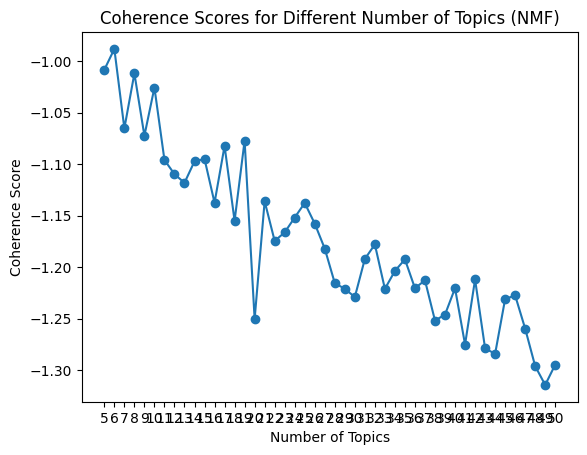

In [21]:
nmf_coherence_scores = []

# Iterate over different numbers of topics
for num_topics in num_topics_range:
    start_time = time.time()
    print(f"NMF: Calculating result for {num_topics} topics...")
    # Fit NMF model
    nmf_model = Nmf(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Compute coherence score
    coherence_model = CoherenceModel(model=nmf_model, texts=texts, corpus=corpus, coherence='u_mass')
    coherence_score = coherence_model.get_coherence()
    nmf_coherence_scores.append(coherence_score)

    end_time = time.time()
    print(f"Took {end_time - start_time:.2f} seconds.")

# Plot coherence scores
plt.plot(num_topics_range, nmf_coherence_scores, marker='o')
plt.title('Coherence Scores for Different Number of Topics (NMF)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_range)
plt.show()

LDA: Calculating result for 5 topics...


Took 15.89 seconds.
LDA: Calculating result for 6 topics...


Took 15.50 seconds.
LDA: Calculating result for 7 topics...


Took 15.92 seconds.
LDA: Calculating result for 8 topics...


Took 16.33 seconds.
LDA: Calculating result for 9 topics...


Took 16.35 seconds.
LDA: Calculating result for 10 topics...


Took 16.68 seconds.
LDA: Calculating result for 11 topics...


Took 16.79 seconds.
LDA: Calculating result for 12 topics...


Took 17.15 seconds.
LDA: Calculating result for 13 topics...


Took 17.17 seconds.
LDA: Calculating result for 14 topics...


Took 21.01 seconds.
LDA: Calculating result for 15 topics...


Took 20.25 seconds.
LDA: Calculating result for 16 topics...


Took 21.58 seconds.
LDA: Calculating result for 17 topics...


Took 21.96 seconds.
LDA: Calculating result for 18 topics...


Took 19.03 seconds.
LDA: Calculating result for 19 topics...


Took 18.42 seconds.
LDA: Calculating result for 20 topics...


Took 18.09 seconds.
LDA: Calculating result for 21 topics...


Took 18.91 seconds.
LDA: Calculating result for 22 topics...


Took 19.25 seconds.
LDA: Calculating result for 23 topics...


Took 19.94 seconds.
LDA: Calculating result for 24 topics...


Took 19.26 seconds.
LDA: Calculating result for 25 topics...


Took 19.03 seconds.
LDA: Calculating result for 26 topics...


Took 31.37 seconds.
LDA: Calculating result for 27 topics...
Took 38.90 seconds.
LDA: Calculating result for 28 topics...


Took 38.44 seconds.
LDA: Calculating result for 29 topics...


Took 23.35 seconds.
LDA: Calculating result for 30 topics...
Took 31.65 seconds.
LDA: Calculating result for 31 topics...


Took 33.83 seconds.
LDA: Calculating result for 32 topics...
Took 21.54 seconds.
LDA: Calculating result for 33 topics...


Took 32.50 seconds.
LDA: Calculating result for 34 topics...


Took 35.72 seconds.
LDA: Calculating result for 35 topics...


Took 24.79 seconds.
LDA: Calculating result for 36 topics...
Took 25.69 seconds.
LDA: Calculating result for 37 topics...


Took 33.30 seconds.
LDA: Calculating result for 38 topics...


Took 31.75 seconds.
LDA: Calculating result for 39 topics...


Took 23.30 seconds.
LDA: Calculating result for 40 topics...
Took 23.01 seconds.
LDA: Calculating result for 41 topics...


Took 24.17 seconds.
LDA: Calculating result for 42 topics...


Took 25.05 seconds.
LDA: Calculating result for 43 topics...


Took 25.60 seconds.
LDA: Calculating result for 44 topics...


Took 24.05 seconds.
LDA: Calculating result for 45 topics...


Took 24.81 seconds.
LDA: Calculating result for 46 topics...


Took 25.79 seconds.
LDA: Calculating result for 47 topics...


Took 24.98 seconds.
LDA: Calculating result for 48 topics...


Took 24.68 seconds.
LDA: Calculating result for 49 topics...


Took 24.46 seconds.
LDA: Calculating result for 50 topics...


Took 25.81 seconds.


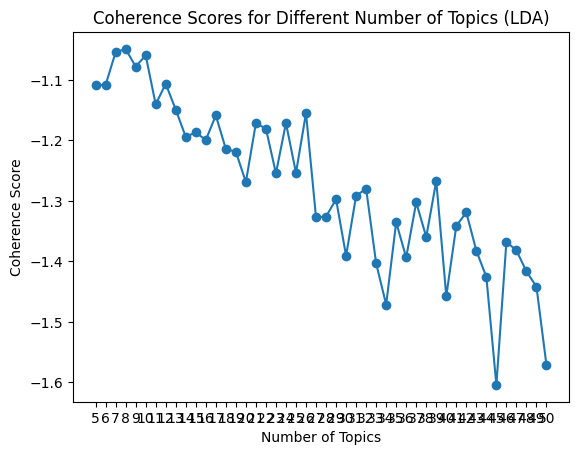

In [26]:
from gensim.models import LdaModel

lda_coherence_scores = []

# Iterate over different numbers of topics
for num_topics in num_topics_range:
    start_time = time.time()
    print(f"LDA: Calculating result for {num_topics} topics...")
    # Fit NMF model
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics,
                         id2word=dictionary, random_state=42)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='u_mass')
    coherence_score = coherence_model.get_coherence()
    lda_coherence_scores.append(coherence_score)

    end_time = time.time()
    print(f"Took {end_time - start_time:.2f} seconds.")

# Plot coherence scores
plt.plot(num_topics_range, lda_coherence_scores, marker='o')
plt.title('Coherence Scores for Different Number of Topics (LDA)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_range)
plt.show()

In [45]:
coherence_scores_df = pd.DataFrame({
    'num_topics': num_topics_range,
    'nmf_umass_score': nmf_coherence_scores,
    'lda_umass_score': lda_coherence_scores
})

coherence_scores_df.head()

,num_topics,nmf_umass_score,lda_umass_score
0,5,-1.008553,-1.108140
1,6,-0.988323,-1.108175
2,7,-1.065393,-1.054153
3,8,-1.012084,-1.048653
4,9,-1.072506,-1.077881


<ipython-input-46-a9adbc07b73a>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


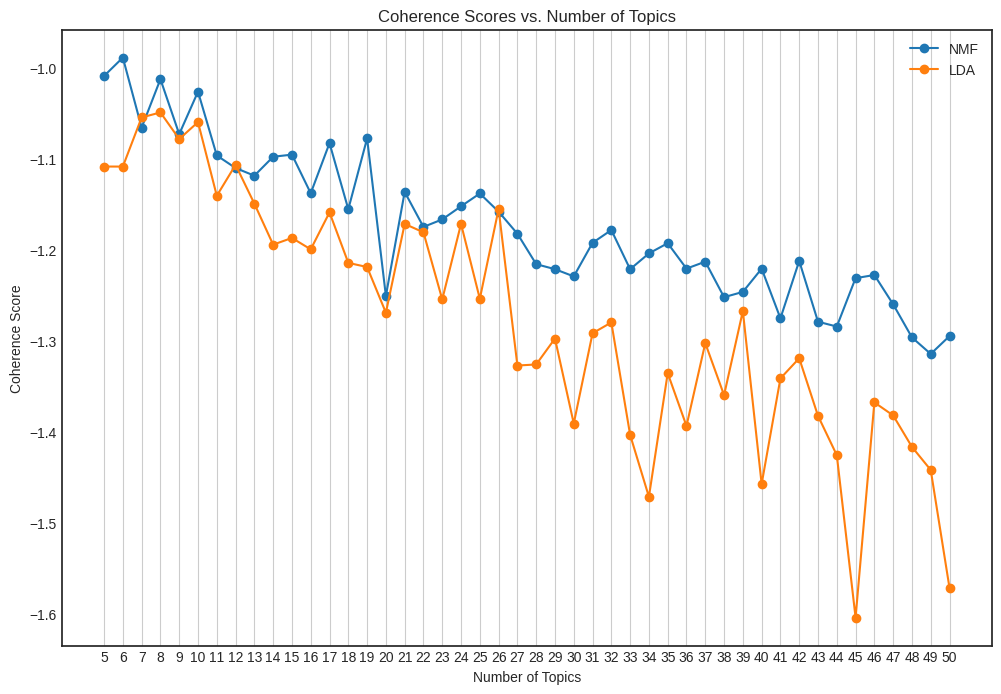

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have the coherence_scores_df DataFrame

# Setting a minimalistic style
plt.style.use('seaborn-white')

# Plotting
plt.figure(figsize=(12, 8))  # Increase the figure size for better visibility

# Plotting the NMF coherence scores
plt.plot(coherence_scores_df['num_topics'], coherence_scores_df['nmf_umass_score'], marker='o', label='NMF')

# Plotting the LDA coherence scores
plt.plot(coherence_scores_df['num_topics'], coherence_scores_df['lda_umass_score'], marker='o', label='LDA')

# Adding labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores vs. Number of Topics')

# Adding legend
plt.legend()

# Customize ticks on the axes to show all number labels
plt.xticks(coherence_scores_df['num_topics'])  # Set x-ticks to match the data points
plt.yticks()  # Auto-generate y-ticks

# Adding vertical gridlines on every tick mark
plt.grid(axis='x', which='both')

# Showing the plot
plt.show()


In [39]:
from datetime import datetime

today = datetime.today()

date_yyyymmdd = today.strftime('%Y%m%d')
date_yyyymmdd = str(date_yyyymmdd)

In [44]:
from google.colab import drive
import os
drive.mount('/content/drive')

# Define the directory path
directory = "/content/drive/My Drive/singapore-parliament-speeches/scores/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

coherence_scores_df.to_csv(f'{directory}scores_{date_yyyymmdd}.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
